In [2]:
from google.colab import drive
drive.mount('/content/drive')

!ls


Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3Aietf%3Awg%3Aoauth%3A2.0%3Aoob&scope=email%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdocs.test%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdrive%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdrive.photos.readonly%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fpeopleapi.readonly&response_type=code

Enter your authorization code:
··········
Mounted at /content/drive
drive  sample_data


In [0]:
!ls

drive  sample_data


In [0]:
!ls drive

'My Drive'


In [0]:
!ls "/content/drive/My Drive/Colab Notebooks"

allimages.ipynb   galaxyclusters.ipynb	     intro.py	       vlass.ipynb
allimages.py	  GaussianFit.ipynb	     nvss.fits
dataimport.ipynb  GaussianFitStudents.ipynb  tensortest.ipynb
dss2blue.fits	  GitTest.ipynb		     VLASSimage.fits


Fitted parameters:
[6.72822714e+01 9.44963528e+01 7.98282258e+00 4.55518378e+00
 8.48585805e-03 1.17454197e+02 8.72219716e+01 8.40503932e+00
 6.28662600e+00 5.38074701e-03]
RMS residual = 0.0005054940362472025


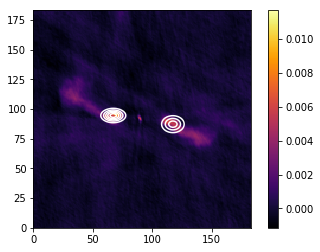

In [8]:
# Brian R. Kent, NRAO
# Loading and displaying a FITS image

# IMPORTS ----------------------------------
from astropy.io import fits
from astropy import wcs

import numpy as np
import matplotlib.pyplot as plt

# VARIABLES -------------------------------
RA =   ( 7.0 +17.0/60.0  +8.00/3600.0) * 15.0
DEC = -(36.0 +21.0/60.0 +58.75/3600.0)
HALF_Width = 92   #(92 pixels is approx. 1.5 arcminutes)
VLASS_FITS = '/content/drive/My Drive/Colab Notebooks/VLASSimage.fits'

import numpy as np
from scipy.optimize import curve_fit
import matplotlib.pyplot as plt

# The two-dimensional domain of the fit.
xmin, xmax, nx = 0, 183, 184
ymin, ymax, ny = 0, 183, 184
x, y = np.linspace(xmin, xmax, nx), np.linspace(ymin, ymax, ny)
X, Y = np.meshgrid(x, y)

# Our function to fit is going to be a sum of two-dimensional Gaussians
def gaussian(x, y, x0, y0, xalpha, yalpha, A):
    return A * np.exp( -((x-x0)/xalpha)**2 -((y-y0)/yalpha)**2)

#1 open VLASS File. This contains HEADER and DATA
hdulist = fits.open(VLASS_FITS)

#2 Use the VLASS FITS header data to create a world coordinate system(wcs)
w = wcs.WCS(hdulist[0].header)

#3 get all the raw data from the VLASS file
VLASS_image_data = fits.getdata(VLASS_FITS)[0,0,:,:]

#4 Put the coordinates into an Array for AstroPy
world = np.array([[RA, DEC, 0.0, 0.0]], np.float_)

#5 Use the WCS to convert from RA/DEC to pixel locations on the image
Pixel_Coord = w.wcs_world2pix(world,1)
xpix = int(round(Pixel_Coord[0][1]))
ypix = int(round(Pixel_Coord[0][0]))

#6 create 4 corners of cutout
lower_x = xpix - HALF_Width
upper_x = xpix + HALF_Width

lower_y = ypix - HALF_Width
upper_y = ypix + HALF_Width

#7 Use the pixel coordinates to make cutout
vlasscutout = VLASS_image_data[lower_x:upper_x,lower_y:upper_y]

Z = vlasscutout

# This is the callable that is passed to curve_fit. M is a (2,N) array
# where N is the total number of data points in Z, which will be ravelled
# to one dimension.
def _gaussian(M, *args):
    x, y = M
    arr = np.zeros(x.shape)
    for i in range(len(args)//5):
       arr += gaussian(x, y, *args[i*5:i*5+5])
    return arr

# Initial guesses to the fit parameters.
guess_prms = [(70, 90, 10, 5.4, 0.01),
         (120, 80, 6, 6, 0.006),
        ]
# Flatten the initial guess parameter list.
p0 = [p for prms in guess_prms for p in prms]

# We need to ravel the meshgrids of X, Y points to a pair of 1-D arrays.
xdata = np.vstack((X.ravel(), Y.ravel()))
# Do the fit, using our custom _gaussian function which understands our
# flattened (ravelled) ordering of the data points.
popt, pcov = curve_fit(_gaussian, xdata, Z.ravel(), p0)
fit = np.zeros(Z.shape)
for i in range(len(popt)//5):
    fit += gaussian(X, Y, *popt[i*5:i*5+5])
print('Fitted parameters:')
print(popt)

rms = np.sqrt(np.mean((Z - fit)**2))
print('RMS residual =', rms)


#8 Plot onto graph with Matplotlib
#plt.imshow(vlasscutout, origin='lower', cmap='inferno')
#plt.colorbar()
#plt.show()

# Plot the test data as a 2D image and the fit as overlaid contours.
fig = plt.figure()
#ax = fig.add_subplot(111)
plt.imshow(Z, origin='bottom', cmap='inferno',
          extent=(x.min(), x.max(), y.min(), y.max()))
plt.colorbar()
plt.contour(X, Y, fit, colors='w')
plt.show()
